# Problema

Transformar imagens de cidades para o estilo cyberpunk.

Vou seguir a linha do CycleGAN, pois os problemas com dados pareados para o Pix2Pix contem menos datasets, e acho muito mais interessante o facto de as ser possivel nao usar dados pareados. 

# Import

In [1]:
import os
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import kagglehub

# para nao deixar o pc suspender enquanto treino os modelos
import subprocess
subprocess.run("killall swayidle", shell=True, capture_output=True, text=True)


CompletedProcess(args='killall swayidle', returncode=1, stdout='', stderr='swayidle: no process found\n')

# Download datasets

In [2]:
cyber_dataset_location = os.path.join(kagglehub.dataset_download("aanisha07/futuristic-images"), "Image_Dataset_256")

# move the files out of their folders
city_dataset_location = os.path.join(kagglehub.dataset_download("vassiliskrikonis/skylines-12"), "data/images")
subfolders = [f for f in os.listdir(city_dataset_location) if os.path.isdir(os.path.join(city_dataset_location, f))]
for folder in subfolders:
    folder_path = os.path.join(city_dataset_location, folder)
    
    # Iterate through files in the subfolder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        
        # Check if it's a file
        if os.path.isfile(file_path):
            # Create new filename with folder prefix
            new_filename = f"{folder}_{filename}"
            new_file_path = os.path.join(city_dataset_location, new_filename)
            
            # Handle potential filename conflicts
            counter = 1
            base, ext = os.path.splitext(new_filename)
            while os.path.exists(new_file_path):
                new_filename = f"{base}_{counter}{ext}"
                new_file_path = os.path.join(city_dataset_location, new_filename)
                counter += 1
            
            # Move the file
            shutil.move(file_path, new_file_path)
            print(f"Moved: {filename} -> {new_filename}")
    
    # Optionally, remove the subfolder if it's empty
    try:
        os.rmdir(folder_path)
        print(f"Removed empty folder: {folder}")
    except OSError:
        print(f"Folder {folder} not empty or could not be removed")

print("Processing complete.")

print(cyber_dataset_location)
print(city_dataset_location)


Processing complete.
/home/ivsopi3/.cache/kagglehub/datasets/aanisha07/futuristic-images/versions/1/Image_Dataset_256
/home/ivsopi3/.cache/kagglehub/datasets/vassiliskrikonis/skylines-12/versions/2/data/images


# Classes

### Image loader

In [3]:
class ImageDataset(Dataset):
    def __init__(self, city_dir, cyber_dir, transform=None, max_images=None):
        self.city_dir = city_dir
        self.cyber_dir = cyber_dir
        self.transform = transform

        self.city_images_path = [os.path.join(city_dir, f) for f in os.listdir(city_dir) if f.endswith(('.jpg', '.png', '.JPG', '.jpeg'))]
        self.cyber_images_path = [os.path.join(cyber_dir, f) for f in os.listdir(cyber_dir) if f.endswith(('.jpg', '.png', '.JPG', '.jpeg'))]

        # use the least amount of images common between both datasets, also allow overloading this
        self.size = min(len(self.city_images_path), len(self.cyber_images_path))
        if max_images:
            self.size = min(self.size, max_images)

        # 10k images should fit in memory, otherwise training is slower
        # idk if DataLoader already preloads things so I'll do it manually
        city_images = []
        cyber_images = []
        print("Preloading images")
        for i in range(self.size):
            try:
                if i % (self.size // 10) == 0:
                    percentage = (i / self.size) * 100
                    print(f"Progress: {percentage:.0f}%")
                city_img = Image.open(self.city_images_path[i]).convert('RGB')
                cyber_img = Image.open(self.cyber_images_path[i]).convert('RGB')
                city_images.append(city_img)
                cyber_images.append(cyber_img)
            except Exception as e:
                print(f"Error at image {i}: {e}, skipping")
                self.size -= 1 # ???
                continue

        self.city_images = city_images
        self.cyber_images = cyber_images
        print(f"loaded {self.size} images")



    def __len__(self):
        return self.size

    # open imgs as rgb, transform if needed. transform is dynamic so it's easier to randomize
    def __getitem__(self, idx):
        city_img = self.city_images[idx]
        cyber_img = self.cyber_images[idx]
        if self.transform:
            city_img = self.transform(city_img)
            cyber_img = self.transform(cyber_img)
        return {'city': city_img, 'cyber': cyber_img}


### Generator - CycleGAN
https://medium.com/@chilldenaya/cyclegan-introduction-pytorch-implementation-5b53913741ca

In [4]:
class ConvolutionalBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        is_downsampling: bool = True,
        **kwargs,
    ):
        super().__init__()
        if is_downsampling:
            self.conv = nn.Conv2d(
                in_channels, out_channels, padding_mode="reflect", **kwargs
            )
        else:
            self.conv = nn.ConvTranspose2d(in_channels, out_channels, **kwargs)

        self.norm = nn.InstanceNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.relu(x)
        return x


class ResidualBlock(nn.Module):
    def __init__(self, channels: int):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, padding_mode="reflect"),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, padding_mode="reflect"),
            nn.InstanceNorm2d(channels),
        )

    def forward(self, x):
        return x + self.block(x)


class Generator(nn.Module):
    def __init__(
        self, img_channels = 3, num_features: int = 64, num_residuals: int = 6
    ):
        """
        Generator consists of 2 layers of downsampling/encoding layer,
        followed by 6 residual blocks for 128 x 128 training images
        and then 3 upsampling/decoding layer.

        The network with 6 residual blocks can be written as:
        c7s1-64, d128, d256, R256, R256, R256, R256, R256, R256, u128, u64, and c7s1-3.
        """
        super().__init__()
        self.initial_layer = nn.Sequential(
            nn.Conv2d(
                img_channels,
                num_features,
                kernel_size=7,
                stride=1,
                padding=3,
                padding_mode="reflect",
            ),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True),
        )

        self.downsampling_layers = nn.ModuleList(
            [
                ConvolutionalBlock(
                    num_features,
                    num_features * 2,
                    is_downsampling=True,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                ),
                ConvolutionalBlock(
                    num_features * 2,
                    num_features * 4,
                    is_downsampling=True,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                ),
            ]
        )

        self.residual_layers = nn.Sequential(
            *[ResidualBlock(num_features * 4) for _ in range(num_residuals)]
        )

        self.upsampling_layers = nn.ModuleList(
            [
                ConvolutionalBlock(
                    num_features * 4,
                    num_features * 2,
                    is_downsampling=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
                ConvolutionalBlock(
                    num_features * 2,
                    num_features * 1,
                    is_downsampling=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
            ]
        )

        self.last_layer = nn.Conv2d(
            num_features * 1,
            img_channels,
            kernel_size=7,
            stride=1,
            padding=3,
            padding_mode="reflect",
        )

    def forward(self, x):
        x = self.initial_layer(x)
        for layer in self.downsampling_layers:
            x = layer(x)
        x = self.residual_layers(x)
        for layer in self.upsampling_layers:
            x = layer(x)
        return torch.tanh(self.last_layer(x))

### Generator - PatchGAN

https://paperswithcode.com/method/patchgan mas mudei para 3 channels em vez dos 6 do pix2pix, onde 2 imagens de 3 canais são concatenadas. Não faz sentido usar aqui, mas não custa experimentar

Não converti o discriminator porque precisa de labels e imagens pareadas

In [5]:
class GeneratorPatchGAN(nn.Module):
    # initializers
    def __init__(self, d=64):
        super(GeneratorPatchGAN, self).__init__()
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d * 2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d * 2)
        self.conv3 = nn.Conv2d(d * 2, d * 4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d * 4)
        self.conv4 = nn.Conv2d(d * 4, d * 8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d * 8)
        self.conv5 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        self.conv5_bn = nn.BatchNorm2d(d * 8)
        self.conv6 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        self.conv6_bn = nn.BatchNorm2d(d * 8)
        self.conv7 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        self.conv7_bn = nn.BatchNorm2d(d * 8)
        self.conv8 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        # self.conv8_bn = nn.BatchNorm2d(d * 8)

        # Unet decoder
        self.deconv1 = nn.ConvTranspose2d(d * 8, d * 8, 4, 2, 1)
        self.deconv1_bn = nn.BatchNorm2d(d * 8)
        self.deconv2 = nn.ConvTranspose2d(d * 8 * 2, d * 8, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d * 8)
        self.deconv3 = nn.ConvTranspose2d(d * 8 * 2, d * 8, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d * 8)
        self.deconv4 = nn.ConvTranspose2d(d * 8 * 2, d * 8, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d * 8)
        self.deconv5 = nn.ConvTranspose2d(d * 8 * 2, d * 4, 4, 2, 1)
        self.deconv5_bn = nn.BatchNorm2d(d * 4)
        self.deconv6 = nn.ConvTranspose2d(d * 4 * 2, d * 2, 4, 2, 1)
        self.deconv6_bn = nn.BatchNorm2d(d * 2)
        self.deconv7 = nn.ConvTranspose2d(d * 2 * 2, d, 4, 2, 1)
        self.deconv7_bn = nn.BatchNorm2d(d)
        self.deconv8 = nn.ConvTranspose2d(d * 2, 3, 4, 2, 1)

    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    def forward(self, input):
        e1 = self.conv1(input)
        e2 = self.conv2_bn(self.conv2(F.leaky_relu(e1, 0.2)))
        e3 = self.conv3_bn(self.conv3(F.leaky_relu(e2, 0.2)))
        e4 = self.conv4_bn(self.conv4(F.leaky_relu(e3, 0.2)))
        e5 = self.conv5_bn(self.conv5(F.leaky_relu(e4, 0.2)))
        e6 = self.conv6_bn(self.conv6(F.leaky_relu(e5, 0.2)))
        e7 = self.conv7_bn(self.conv7(F.leaky_relu(e6, 0.2)))
        e8 = self.conv8(F.leaky_relu(e7, 0.2))
        # e8 = self.conv8_bn(self.conv8(F.leaky_relu(e7, 0.2)))
        d1 = F.dropout(self.deconv1_bn(self.deconv1(F.relu(e8))), 0.5, training=True)
        d1 = torch.cat([d1, e7], 1)
        d2 = F.dropout(self.deconv2_bn(self.deconv2(F.relu(d1))), 0.5, training=True)
        d2 = torch.cat([d2, e6], 1)
        d3 = F.dropout(self.deconv3_bn(self.deconv3(F.relu(d2))), 0.5, training=True)
        d3 = torch.cat([d3, e5], 1)
        d4 = self.deconv4_bn(self.deconv4(F.relu(d3)))
        # d4 = F.dropout(self.deconv4_bn(self.deconv4(F.relu(d3))), 0.5)
        d4 = torch.cat([d4, e4], 1)
        d5 = self.deconv5_bn(self.deconv5(F.relu(d4)))
        d5 = torch.cat([d5, e3], 1)
        d6 = self.deconv6_bn(self.deconv6(F.relu(d5)))
        d6 = torch.cat([d6, e2], 1)
        d7 = self.deconv7_bn(self.deconv7(F.relu(d6)))
        d7 = torch.cat([d7, e1], 1)
        d8 = self.deconv8(F.relu(d7))
        o = F.tanh(d8)

        return o

def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()


### Discriminators - CycleGAN
https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/

In [6]:
# inspired from CycleGAN https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
        )

    def forward(self, x):
        return self.model(x)

### Training

Data

In [7]:
# models and data are kept as global vars to be reused and avoid a memory leak issue

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = ImageDataset(city_dataset_location, cyber_dataset_location, transform=transform, max_images=500)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

Preloading images
Progress: 0%
Progress: 10%
Progress: 20%
Progress: 30%
Progress: 40%
Progress: 50%
Progress: 60%
Progress: 70%
Progress: 80%
Progress: 90%
loaded 120 images


Models

In [8]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

gen_City2Cyber = Generator().to(device)
gen_Cyber2City = Generator().to(device)
disc_City = Discriminator().to(device)
disc_Cyber = Discriminator().to(device)

Train

In [9]:
def train(epochs=100, lr=0.0002, save_dir='output'):
    
    # Losses
    criterion_GAN = nn.MSELoss()
    criterion_cycle = nn.L1Loss()
    criterion_identity = nn.L1Loss()
    
    # Optimizers
    optimizer_G = optim.Adam(list(gen_City2Cyber.parameters()) + list(gen_Cyber2City.parameters()), lr=lr, betas=(0.5, 0.999))
    optimizer_D_City = optim.Adam(disc_City.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_D_Cyber = optim.Adam(disc_Cyber.parameters(), lr=lr, betas=(0.5, 0.999))
    
    os.makedirs(save_dir, exist_ok=True)
    
    for epoch in range(epochs):
        for i, data in enumerate(dataloader):
            real_City = data['city'].to(device)
            real_Cyber = data['cyber'].to(device)
            
            # Ground truth for discriminators
            real_label = torch.ones(real_City.size(0), 1, 30, 30).to(device)  # PatchGAN output size
            fake_label = torch.zeros(real_City.size(0), 1, 30, 30).to(device)
            
            ########## train generators ##########
            optimizer_G.zero_grad()
            
            # Identity loss
            identity_City = gen_Cyber2City(real_City)
            identity_Cyber = gen_City2Cyber(real_Cyber)
            loss_identity = (criterion_identity(identity_City, real_City) + criterion_identity(identity_Cyber, real_Cyber)) * 5.0
            
            # GAN loss
            fake_City = gen_City2Cyber(real_City)
            pred_fake_Cyber = disc_Cyber(fake_City)
            loss_GAN_City2Cyber = criterion_GAN(pred_fake_Cyber, real_label)
            
            fake_City = gen_Cyber2City(real_Cyber)
            pred_fake_City = disc_City(fake_City)
            loss_GAN_Cyber2City = criterion_GAN(pred_fake_City, real_label)
            
            # Cycle consistency loss
            rec_City = gen_Cyber2City(fake_City)
            rec_Cyber = gen_City2Cyber(fake_City)
            loss_cycle = (criterion_cycle(rec_City, real_City) + criterion_cycle(rec_Cyber, real_Cyber)) * 10.0
            
            # Total generator loss
            loss_G = loss_GAN_City2Cyber + loss_GAN_Cyber2City + loss_cycle + loss_identity
            loss_G.backward()
            optimizer_G.step()
            
            ########## train discriminators ##########
            # city
            optimizer_D_City.zero_grad()
            pred_real_City = disc_City(real_City)
            loss_D_real_City = criterion_GAN(pred_real_City, real_label)
            pred_fake_City = disc_City(fake_City.detach())
            loss_D_fake_City = criterion_GAN(pred_fake_City, fake_label)
            loss_D_City = (loss_D_real_City + loss_D_fake_City) * 0.5
            loss_D_City.backward()
            optimizer_D_City.step()
            
            # cyber
            optimizer_D_Cyber.zero_grad()
            pred_real_Cyber = disc_Cyber(real_Cyber)
            loss_D_real_Cyber = criterion_GAN(pred_real_Cyber, real_label)
            pred_fake_Cyber = disc_Cyber(fake_City.detach())
            loss_D_fake_Cyber = criterion_GAN(pred_fake_Cyber, fake_label)
            loss_D_Cyber = (loss_D_real_Cyber + loss_D_fake_Cyber) * 0.5
            loss_D_Cyber.backward()
            optimizer_D_Cyber.step()
            
            # progress at the start of the epoch
            if i % 100 == 0:
                print(f"Epoch [{epoch+1}/{epochs}] Batch [{i}/{len(dataloader)}] "
                      f"Loss_G: {loss_G.item():.4f} Loss_D_City: {loss_D_City.item():.4f} Loss_D_Cyber: {loss_D_Cyber.item():.4f}")
            
            # example image every 1000 batches just because
            # TODO: why is this only writing at epoch 0?????
            if i % 1000 == 0:
                with torch.no_grad():
                    fake_City = gen_City2Cyber(real_City)
                    img = fake_City[0].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5  # Denormalize
                    plt.imsave(os.path.join(save_dir, f'epoch_{epoch+1}_batch_{i}_fake_cyber.png'), img)
    
        # save model every 5 epochs
        if (epoch + 1) % 5 == 0:
            torch.save(gen_City2Cyber.state_dict(), os.path.join(save_dir, f'gen_City2Cyber.pth'))
            torch.save(gen_Cyber2City.state_dict(), os.path.join(save_dir, f'gen_Cyber2City.pth'))
            torch.save(disc_City.state_dict(), os.path.join(save_dir, f'disc_City.pth'))
            torch.save(disc_Cyber.state_dict(), os.path.join(save_dir, f'disc_Cyber.pth'))
            print("Saved")

train(epochs=5, lr=0.0002, save_dir='output')


Epoch [1/5] Batch [0/15] Loss_G: 22.4082 Loss_D_City: 0.5845 Loss_D_Cyber: 1.3882
Epoch [2/5] Batch [0/15] Loss_G: 11.6118 Loss_D_City: 0.2199 Loss_D_Cyber: 0.7990
Epoch [3/5] Batch [0/15] Loss_G: 9.5406 Loss_D_City: 0.1748 Loss_D_Cyber: 0.1262
Epoch [4/5] Batch [0/15] Loss_G: 9.0194 Loss_D_City: 0.2553 Loss_D_Cyber: 0.1154
Epoch [5/5] Batch [0/15] Loss_G: 9.4595 Loss_D_City: 0.2563 Loss_D_Cyber: 0.1269
Saved


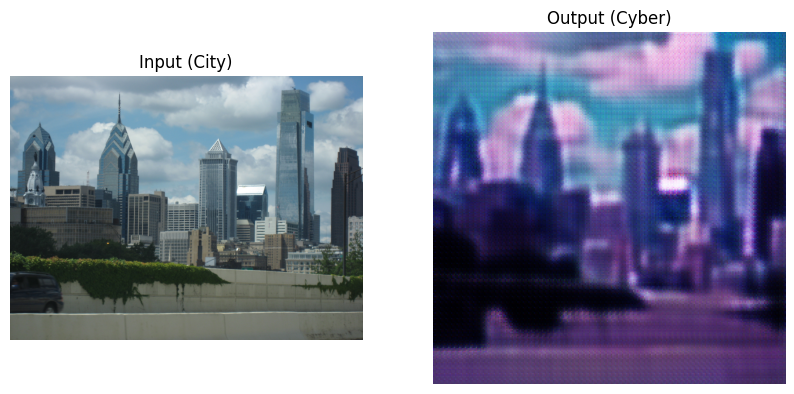

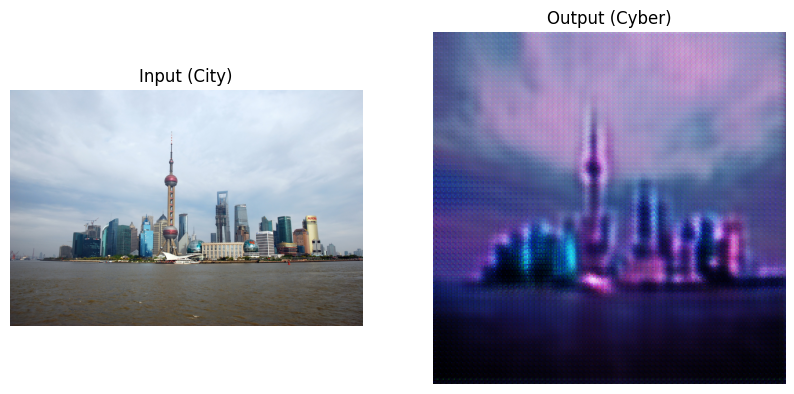

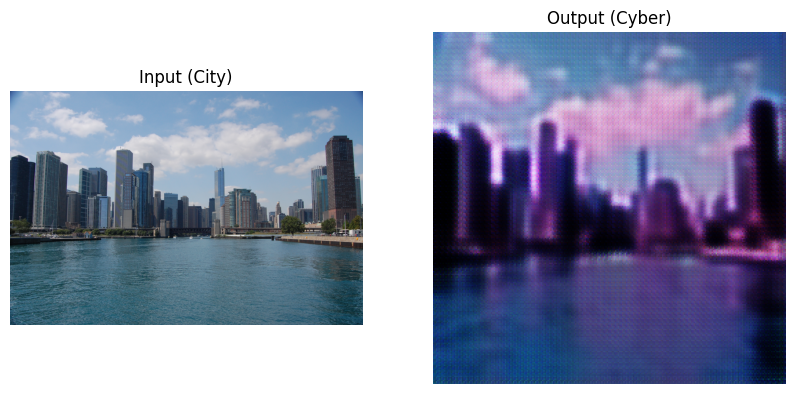

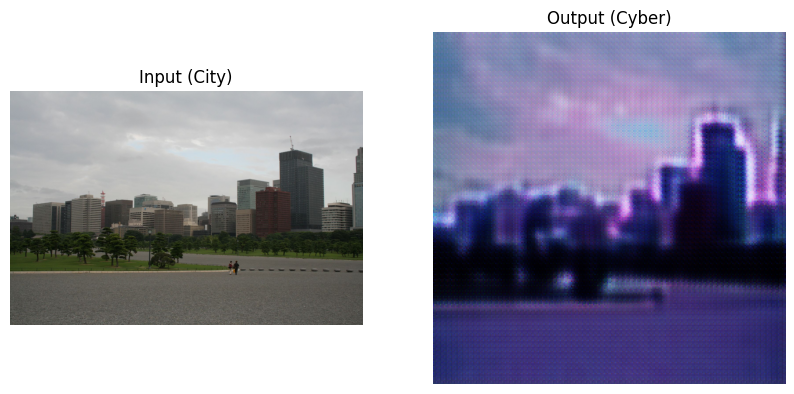

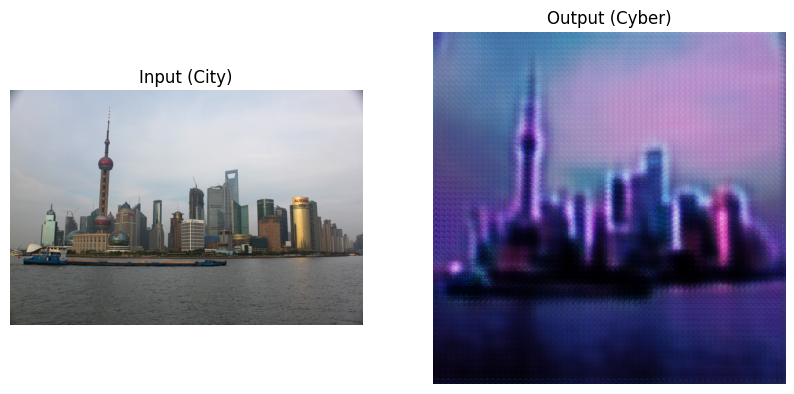

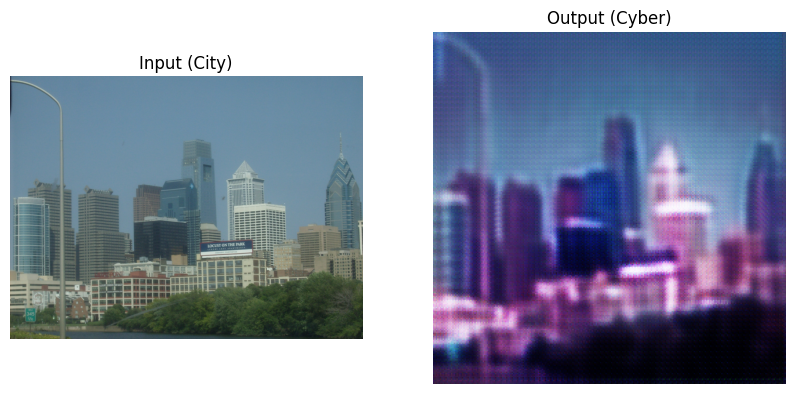

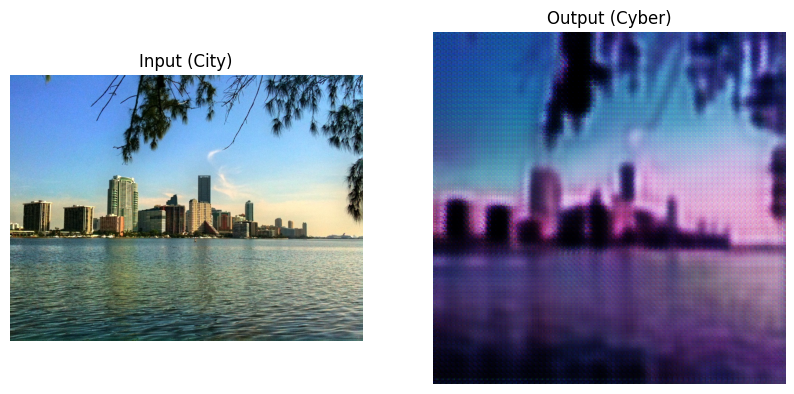

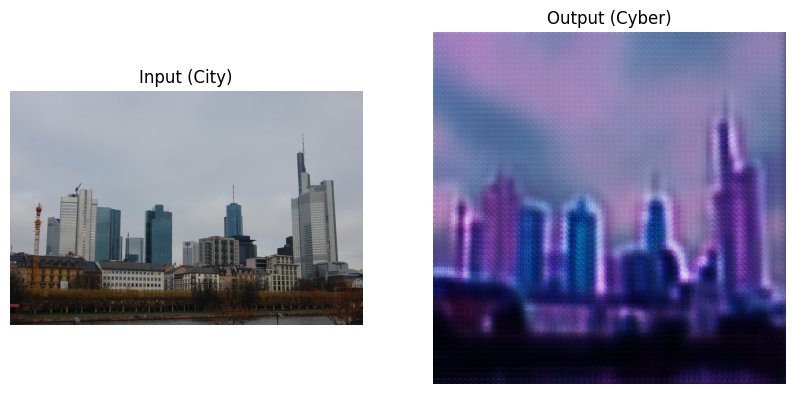

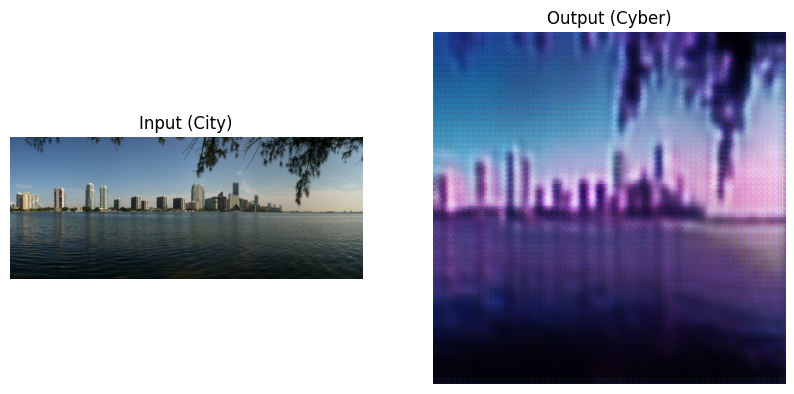

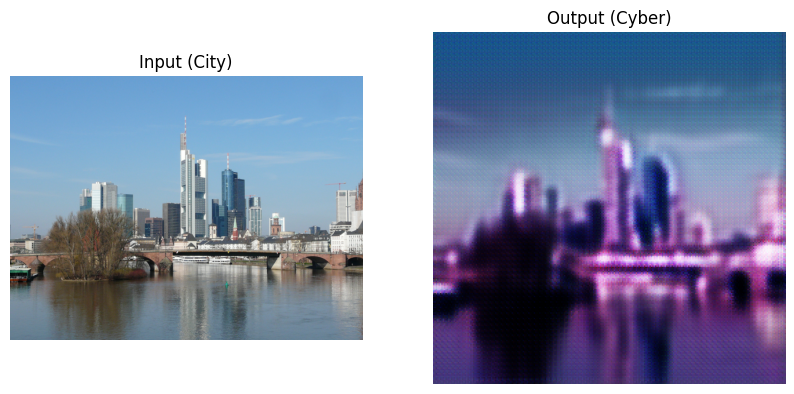

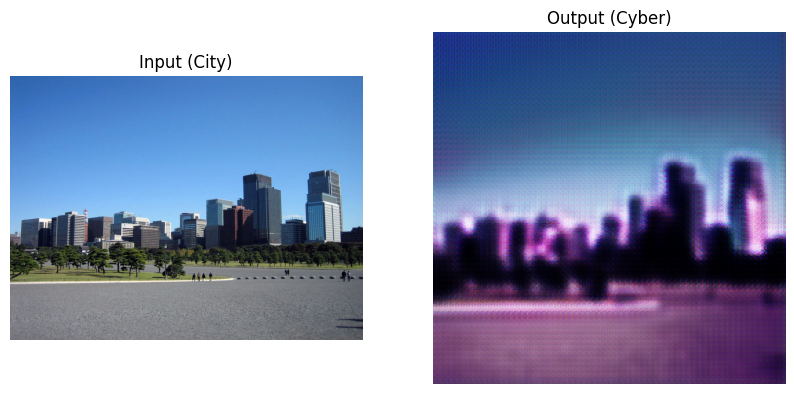

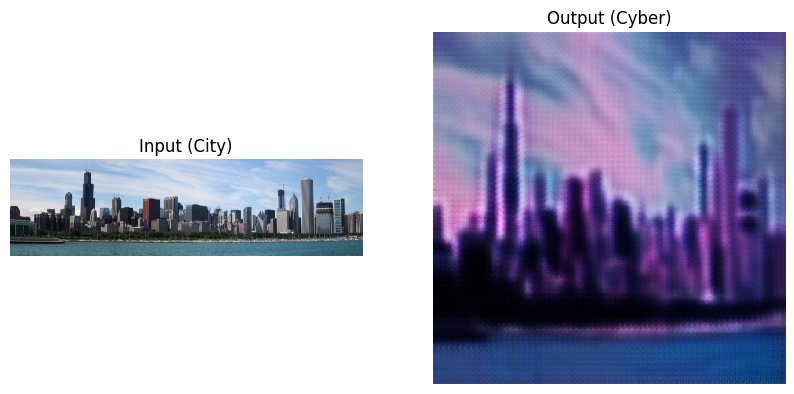

In [10]:
def infer_cyclegan(input_dir, output_dir, model_path, device='cuda' if torch.cuda.is_available() else 'cpu'):
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Define image transforms (must match training)
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    # Load generator model
    gen_City2Cyber = Generator().to(device)
    gen_City2Cyber.load_state_dict(torch.load(model_path, map_location=device))
    gen_City2Cyber.eval()
    
    # Get list of input images
    input_images = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith(('.jpg', '.png'))]
    
    # Process each image
    for img_path in input_images:
        # Load and preprocess image
        img = Image.open(img_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension
        
        # Generate cyber-style image
        with torch.no_grad():
            fake_cyber = gen_City2Cyber(img_tensor)
        
        # Denormalize and convert to PIL image
        fake_cyber = fake_cyber.squeeze(0).cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5
        fake_cyber = (fake_cyber * 255).astype(np.uint8)
        output_img = Image.fromarray(fake_cyber)
        
        # # Save output
        # output_path = os.path.join(output_dir, f"cyber_{os.path.basename(img_path)}")
        # output_img.save(output_path)
        # print(f"Saved: {output_path}")
        
        # Optional: Display input and output (comment out if not needed)
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title("Input (City)")
        plt.imshow(img)
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.title("Output (Cyber)")
        plt.imshow(output_img)
        plt.axis('off')
        plt.show()



input_dir = 'input'  # Directory with test city images
output_dir = 'results'     # Directory to save cybers-style images

infer_cyclegan(input_dir, output_dir, 'output/gen_City2Cyber.pth')